# Proyecto 03 - Procesamiento del Lenguaje Natural

## Dataset: The Multilingual Amazon Reviews Corpus

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Es un archivo .zip que contiene tres documentos. Más información sobre el dataset [aquí](https://registry.opendata.aws/amazon-reviews-ml/). Es importante que tengas en cuenta la [licencia](https://docs.opendata.aws/amazon-reviews-ml/license.txt) de este dataset.**

### Exploración de datos y Procesamiento del Lenguaje Natural

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Considera que hasta que no hayas aplicado las herramientas de Procesamiento del Lenguaje Natural vistas, será difícil completar este análisis. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿qué palabras están asociadas a calificaciones positivas y qué palabras a calificaciones negativas?

### Machine Learning

Implementa un modelo que, dada la crítica de un producto, asigne la cantidad de estrellas correspondiente. **Para pensar**: ¿es un problema de Clasificación o de Regresión?

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?

**Recomendación:** si no te resulta conveniente trabajar en español con NLTK, te recomendamos que explores la librería [spaCy](https://spacy.io/).

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Valdrá la pena convertir el problema de Machine Learning en un problema binario? Es decir, asignar únicamente las etiquetas Positiva y Negativa a cada crítica y hacer un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta. Pensar en qué situación puede ser útil. ¿Esperas que el desempeño sea mejor o peor?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

# GITHUB: https://github.com/Maartjehey/Proyecto-03-Acamica

### Parte A: Exploración de Datos

### 1. Importamos y Cargamos el Dataset

In [1]:
import itertools
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import nltk

# Esto sirve para configurar NLTK. La primera vez puede tardar un poco
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Maartje\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Maartje\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
dataset = pd.read_json("dataset_es_train.json", lines=True
            )
dataset.head()


,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,es,drugstore
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,es,wireless
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,es,shoes


In [3]:
dataset.shape

(200000, 8)

Primero filtramos las columnas que vamos a necesitar. Son las que contienen las reseñas: *review_body* y *review title*, el target es *stars*

In [4]:
dataset_reviews=pd.concat([dataset.review_body,dataset.review_title, dataset.stars],axis=1)
dataset_reviews.dropna(axis=0,inplace=True)  # Si hay alguna nan, tiramos esa instancia
dataset_reviews.head()

,review_body,review_title,stars
0,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,1
1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,1
2,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,1
3,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,1
4,Llega tarde y co la talla equivocada,Devuelto,1


In [5]:
dataset['stars'].value_counts()

1    40000
2    40000
3    40000
4    40000
5    40000
Name: stars, dtype: int64

C:\Users\Maartje\anaconda3\envs\acamica\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


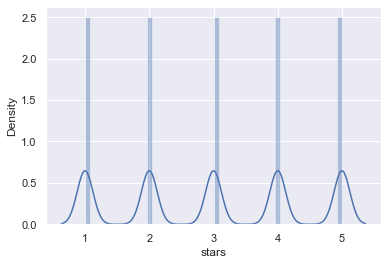

In [6]:
import seaborn as sns
sns.distplot(dataset['stars']);


### 2. Tokenización y Normalización

Con el fin de que nuestra computadora entienda cualquier texto, tenemos que cortar las palabras de una manera en que nuestra máquina puede entender. Ahí es donde entra el concepto de tokenización en el Procesamiento del Lenguaje Natural. En pocas palabras, no podemos trabajar con datos de texto si no realizamos la tokenización. 
Creamos una lista vacia y agregamos en esa lista todos los titulares ya tokenizados, usando el RegexpTokenizer, y filtrado por stopwords.

Importamos los *stopwords* y filtramos el dataset por estos stopwords.

In [7]:
stopwords = nltk.corpus.stopwords.words('spanish')

In [8]:
todos_titulares = []
for i in range(dataset_reviews.shape[0]):
    titular = dataset_reviews.iloc[i].review_body
    titular = dataset_reviews.iloc [i].review_title
    titular = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(titular)
    titular = [word for word in titular if word not in stopwords]

    todos_titulares.append(titular)

Los primeros diez palabras en nuestra nueva lista son: 

In [9]:
todos_titulares = list(itertools.chain(*todos_titulares))
todos_titulares[0:10]

['television',
 'Nevir',
 'Dinero',
 'tirado',
 'basura',
 'compra',
 'solo',
 'llega',
 'unidad',
 'obligan']

Las palabras mas frequentes del dataset_reviews son:

In [10]:
freq_reviews = nltk.FreqDist(todos_titulares)
freq_reviews

FreqDist({'No': 19751, 'calidad': 11716, 'Muy': 9687, 'bien': 8268, 'precio': 7684, 'Buena': 6329, 'producto': 5598, 'Buen': 5103, 'Calidad': 3440, 'buena': 3427, ...})

Lo llevamos a un dataframe con dos columnas: *words* y *frequency*, con el index original. 

In [11]:
df_reviews= pd.DataFrame(list(freq_reviews.items()), columns = ["Word","Frequency"])
df_reviews.head()

,Word,Frequency
0,television,3
1,Nevir,1
2,Dinero,105
3,tirado,102
4,basura,160


Ahora vamos a ordenarlos por *frequency* en que aparece cada palabra:

In [12]:
df_reviews.sort_values('Frequency',ascending=False, inplace = True)
df_reviews.head()

,Word,Frequency
21,No,19751
24,calidad,11716
64,Muy,9687
534,bien,8268
642,precio,7684


Y renovamos el index:

In [13]:
df_reviews.reset_index(drop = True, inplace=True)
df_reviews.head()

,Word,Frequency
0,No,19751
1,calidad,11716
2,Muy,9687
3,bien,8268
4,precio,7684


Hacemos un barplot para visualizarlo:

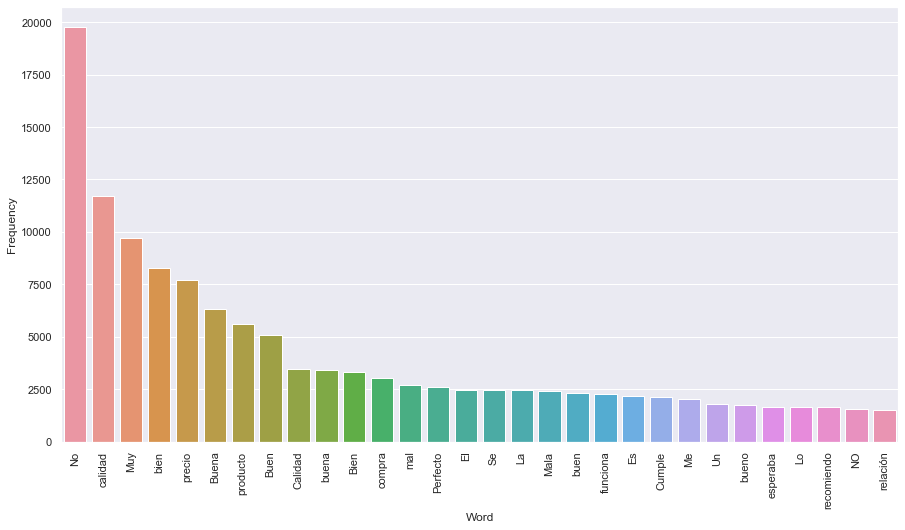

In [14]:
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_reviews.iloc[:30].Word, y = df_reviews.iloc[:30].Frequency)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

Podemos filtrar mas palabras, aparte de las que aparecen en *stopwords*. Escogemos las palabras que aparecen en el barplot y según su significado no tienen que ver con opinion, y que por esta razón no nos serviría etrenarlo con el modelo: "El","La", "Se", "Es", "Me", "Un", "Lo",  

Lo hariamos junto con el Stemming - con la funcion *len(palabra)>3*

### 3. STEMMING

El stemming hace que los datos de entrenamiento sean más densos. Se reduce el tamaño del diccionario (número de palabras utilizadas en el corpus) dos o tres veces (aún más para los idiomas con muchas flecciones como el español, donde una sola raíz puede generar docenas de palabras en caso de verbos, por ejemplo).

Teniendo el mismo cuerpo, pero menos dimensiones de entrada, ML funcionará mejor. Recall realmente debería ser mejor.

La desventaja es que, si en algunos casos la palabra real (en lugar de su raíz) hace una diferencia, entonces su sistema no será capaz de aprovecharla. Así que podrías perder algo de precisión.

En nuestro caso estamos viendo más a adjetivos - y podemos stemmatizar bastante :-)

Antes de realizar el proceso de Stemming, vamos a normalizar el texto. Le agregamos en este caso el uso de la libreria *re*, que nos permite sacar del texto todos los caracteres que no sean palabras. Notemos que hay veces que no conviene quitar estos caracteres ya que, por ejemplo, no podremos distiguir preguntas (?) o exclamaciones (!).

In [15]:
# Importamos esta libreria que nos permite reemplzar caracteres
import re

# Importamos la función que nos permite Stemmizar de nltk y definimos el stemmer
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

# Traemos nuevamente las stopwords
stopwords = nltk.corpus.stopwords.words('spanish')
#stopword.remove('no')
#stopword.remove('nada')

In [16]:
dataset = pd.read_json("dataset_es_train.json", lines=True
            )

In [17]:
dataset=pd.concat([dataset.review_body,dataset.review_title],axis=1)
dataset.dropna(axis=0,inplace=True)  # Si hay alguna nan, tiramos esa instancia
dataset.head()

,review_body,review_title
0,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir
1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra
2,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...
3,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.
4,Llega tarde y co la talla equivocada,Devuelto


In [18]:
from tqdm import tqdm


In [19]:
# Recorremos todos los titulos y le vamos aplicando la Normalizacion y luega el Stemming a cada uno
titular_list_body=[]
for titular in tqdm(dataset.review_body):
    # Vamos a reemplzar los caracteres que no sean leras por espacios
    titular=re.sub("[^a-zA-Z]"," ",str(titular))
    # Pasamos todo a minúsculas
    titular=titular.lower()
    # Tokenizamos para separar las palabras del titular
    titular=nltk.word_tokenize(titular)
    # Eliminamos las palabras de menos de 3 letras
    titular = [palabra for palabra in titular if len(palabra)>3]
    # Sacamos las Stopwords
    titular = [palabra for palabra in titular if not palabra in stopwords]
    
    ## Hasta acá Normalizamos, ahora a stemmizar
    
    # Aplicamos la funcion para buscar la raiz de las palabras
    titular=[stemmer.stem(palabra) for palabra in titular]
    # Por ultimo volvemos a unir el titular
    titular=" ".join(titular)
    
    # Vamos armando una lista con todos los titulares
    titular_list_body.append(titular)
    #dataset["titular_normalizado"] = titular_list


100%|█████████████████████████████████████████████████████████████████████████| 200000/200000 [05:56<00:00, 560.41it/s]


Agregamos al dataset una columna llamado *titular_stem_body* que contenga los titulares stemmizados de la columna *dataset_reviews.review_body*:

In [20]:
dataset["titular_stem_body"] = titular_list_body
dataset.tail()

,review_body,review_title,titular_stem_body
199995,Mando funciona perfectamente y cumple con toda...,Tal y como se describe,mando funciona perfectament cumpl toda funcion...
199996,"Compré la batería con cierta reticencia, pero ...",Funciona perfectamente,compr bater cierta reticencia result instalar ...
199997,Buena calidad. Satisfecha con la compra.,Buena calidad.,buena calidad satisfecha compra
199998,Perfecto para el cumple de mi hijo,Recomendado,perfecto cumpl hijo
199999,"Súper bien! Las brochas son buenas, no sé meno...",Preciosas,bien brocha buena meno pelito quiz pesan chula...


In [21]:
# Recorremos todos los titulos y le vamos aplicando la Normalizacion y luego el Stemming a cada uno
titular_list_title=[]
for titular in tqdm(dataset_reviews.review_title):
    # Vamos a reemplzar los caracteres que no sean leras por espacios
    titular=re.sub("[^a-zA-Z]"," ",str(titular))
    # Pasamos todo a minúsculas
    titular=titular.lower()
    # Tokenizamos para separar las palabras del titular
    titular=nltk.word_tokenize(titular)
    # Eliminamos las palabras de menos de 3 letras
    titular = [palabra for palabra in titular if len(palabra)>3]
    # Sacamos las Stopwords
    titular = [palabra for palabra in titular if not palabra in stopwords]
    
    ## Hasta acá Normalizamos, ahora a stemmizar
    
    # Aplicamos la funcion para buscar la raiz de las palabras
    titular=[stemmer.stem(palabra) for palabra in titular]
    # Por ultimo volvemos a unir el titular
    titular=" ".join(titular)
    
    # Vamos armando una lista con todos los titulares
    titular_list_title.append(titular)
    #dataset["titular_normalizado"] = titular_list

100%|█████████████████████████████████████████████████████████████████████████| 200000/200000 [04:53<00:00, 681.54it/s]


Hacemos lo mismo para la columna *dataset_reviews.review_title*:

In [22]:
dataset["titular_stem_title"] = titular_list_title
dataset.tail()

,review_body,review_title,titular_stem_body,titular_stem_title
199995,Mando funciona perfectamente y cumple con toda...,Tal y como se describe,mando funciona perfectament cumpl toda funcion...,describ
199996,"Compré la batería con cierta reticencia, pero ...",Funciona perfectamente,compr bater cierta reticencia result instalar ...,funciona perfectament
199997,Buena calidad. Satisfecha con la compra.,Buena calidad.,buena calidad satisfecha compra,buena calidad
199998,Perfecto para el cumple de mi hijo,Recomendado,perfecto cumpl hijo,recomendado
199999,"Súper bien! Las brochas son buenas, no sé meno...",Preciosas,bien brocha buena meno pelito quiz pesan chula...,preciosa


In [23]:
dataset_stem=pd.concat([dataset.review_body, dataset.titular_stem_body, dataset.review_title, dataset.titular_stem_title],axis=1)
dataset_stem.dropna(axis=0,inplace=True)  # Por si quedaron titulares vacios
dataset_stem.head()

,review_body,titular_stem_body,review_title,titular_stem_title
0,Nada bueno se me fue ka pantalla en menos de 8...,bueno pantalla meno mese recibido respuesta fa...,television Nevir,televis nevir
1,"Horrible, nos tuvimos que comprar otro porque ...",horribl comprar sabemo ingl inform tico despu ...,Dinero tirado a la basura con esta compra,dinero tirado basura compra
2,Te obligan a comprar dos unidades y te llega s...,obligan comprar unidad llega solo forma reclam...,solo llega una unidad cuando te obligan a comp...,solo llega unidad obligan comprar
3,"No entro en descalificar al vendedor, solo pue...",entro descalificar vendedor solo puedo decir t...,PRODUCTO NO RECIBIDO.,producto recibido
4,Llega tarde y co la talla equivocada,llega tard talla equivocada,Devuelto,devuelto


In [24]:
freq_reviews1 = nltk.FreqDist(titular_list_body)
freq_reviews1

FreqDist({'buena relaci calidad precio': 239, 'esperaba': 150, 'buena calidad precio': 133, 'cumpl expectativa': 69, 'bien precio': 68, 'llegado': 60, 'recibido': 55, 'calidad precio bien': 53, 'buena calidad': 51, 'precio bien': 51, ...})

In [25]:
df_reviews1= pd.DataFrame(list(freq_reviews1.items()), columns = ["Word","Frequency"])
df_reviews1.head()

,Word,Frequency
0,bueno pantalla meno mese recibido respuesta fa...,1
1,horribl comprar sabemo ingl inform tico despu ...,1
2,obligan comprar unidad llega solo forma reclam...,1
3,entro descalificar vendedor solo puedo decir t...,1
4,llega tard talla equivocada,1


In [26]:
df_reviews1.sort_values('Frequency',ascending=False, inplace = True)
df_reviews1.head()

,Word,Frequency
14888,buena relaci calidad precio,239
1276,esperaba,150
78824,buena calidad precio,133
32690,cumpl expectativa,69
42498,bien precio,68


In [27]:
df_reviews1.reset_index(drop = True, inplace=True)
df_reviews1.head()

,Word,Frequency
0,buena relaci calidad precio,239
1,esperaba,150
2,buena calidad precio,133
3,cumpl expectativa,69
4,bien precio,68


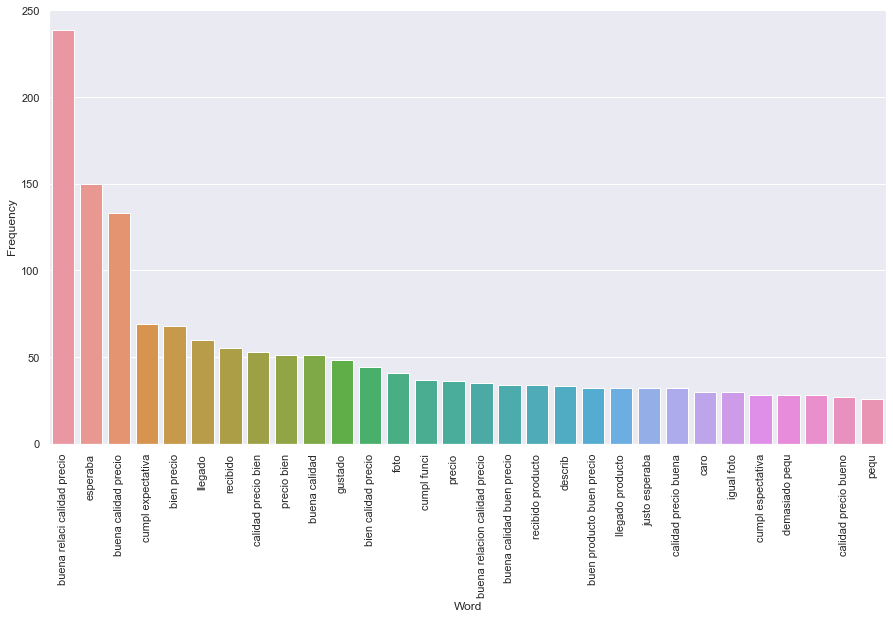

In [28]:
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_reviews1.iloc[:30].Word, y = df_reviews1.iloc[:30].Frequency)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

La verdad es que no podemos usar esta nueva columna, porque las palabras ya no tienen significado. por el Stemmatizer. Vamos a ver que hace el Lemmatizer: 

### 4. LEMMATIZATION

El objetivo tanto del *stemming* como de la *lemmatization* es reducir las formas de inflexión y, a veces, las formas derivacionalmente relacionadas de una palabra a una forma de base común.

In [29]:
#nltk.download()

In [30]:
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [31]:
# Importamos esta libreria que nos permite reemplzar caracteres
import re

# Importamos el lemmatizar de NLTK, y creamos el objeto
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

In [32]:
# Importamos el lemmatizar de NLTK, y creamos el objeto
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# Importamos esta libreria que nos permite reemplzar caracteres
import re

dataset = pd.read_json("dataset_es_train.json", lines= True)
dataset_lemmatizer = pd.concat([dataset.review_body,dataset.review_title, dataset.stars],axis=1)
dataset_lemmatizer.dropna(axis=0,inplace=True)

# Traemos nuevamente las stopwords
stopwords = nltk.corpus.stopwords.words('spanish')
#stopword.remove('no')
#stopword.remove('not')

In [33]:
dataset_lemmatizer.head()

,review_body,review_title,stars
0,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,1
1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,1
2,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,1
3,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,1
4,Llega tarde y co la talla equivocada,Devuelto,1


In [34]:
from tqdm import tqdm

titular_list_lem_body=[]
for titular in tqdm(dataset_lemmatizer.review_body):
    # Vamos a reemplzar los caracteres que no sean leras por espacios
    titular=re.sub("[^a-zA-Z]"," ",str(titular))
    # Pasamos todo a minúsculas
    titular=titular.lower()
    # Tokenizamos para separar las palabras
    titular=nltk.word_tokenize(titular)
    
    # Aplicamos el Lemmatizer (Esto puede tardar un ratito)
    titular = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in titular]
    
    
    # Eliminamos las palabras d emenos de 3 letras
    titular = [palabra for palabra in titular if len(palabra)>3]
    # Sacamos las Stopwords
    titular = [palabra for palabra in titular if not palabra in stopwords]
    
    # Por ultimo volvemos a unir el titular
    titular=" ".join(titular)
    #dataset["titular_normalizado"] = titular_list
    titular_list_lem_body.append(titular)

100%|████████████████████████████████████████████████████████████████████████| 200000/200000 [3:08:22<00:00, 17.70it/s]


In [35]:
dataset_lemmatizer["titular_lem_body"] = titular_list_lem_body
dataset_lemmatizer.head()

,review_body,review_title,stars,titular_lem_body
0,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,1,bueno pantalla menos recibido respuesta fabric...
1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,1,horrible comprar sabemos ingl inform tico desp...
2,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,1,obligan comprar unidades llega solo forma recl...
3,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,1,entro descalificar vendedor solo puedo decir t...
4,Llega tarde y co la talla equivocada,Devuelto,1,llega tarde talla equivocada


In [36]:
dataset_lem=pd.concat([dataset_lemmatizer.review_body, dataset_lemmatizer.review_title, dataset_lemmatizer.titular_lem_body, dataset_lemmatizer.stars],axis=1)
#dataset_stem.dropna(axis=0,inplace=True)  # Por si quedaron titulares vacios
dataset_lem.head()

,review_body,review_title,titular_lem_body,stars
0,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,bueno pantalla menos recibido respuesta fabric...,1
1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,horrible comprar sabemos ingl inform tico desp...,1
2,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,obligan comprar unidades llega solo forma recl...,1
3,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,entro descalificar vendedor solo puedo decir t...,1
4,Llega tarde y co la talla equivocada,Devuelto,llega tarde talla equivocada,1


In [37]:
from tqdm import tqdm

titular_list_lem_title=[]
for titular in tqdm(dataset_lemmatizer.review_title):
    # Vamos a reemplzar los caracteres que no sean leras por espacios
    titular=re.sub("[^a-zA-Z]"," ",str(titular))
    # Pasamos todo a minúsculas
    titular=titular.lower()
    # Tokenizamos para separar las palabras
    titular=nltk.word_tokenize(titular)
    
    # Aplicamos el Lemmatizer (Esto puede tardar un ratito)
    titular = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in titular]
    
    
    # Eliminamos las palabras d emenos de 3 letras
    titular = [palabra for palabra in titular if len(palabra)>3]
    # Sacamos las Stopwords
    titular = [palabra for palabra in titular if not palabra in stopwords]
    
    # Por ultimo volvemos a unir el titular
    titular=" ".join(titular)
    #dataset["titular_normalizado"] = titular_list
    titular_list_lem_title.append(titular)

100%|█████████████████████████████████████████████████████████████████████████| 200000/200000 [23:43<00:00, 140.53it/s]


In [38]:
dataset_lem["titular_lem_title"] = titular_list_lem_title
dataset_lem.head()

,review_body,review_title,titular_lem_body,stars,titular_lem_title
0,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,bueno pantalla menos recibido respuesta fabric...,1,television nevir
1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,horrible comprar sabemos ingl inform tico desp...,1,dinero tirado basura compra
2,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,obligan comprar unidades llega solo forma recl...,1,solo llega unidad obligan comprar
3,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,entro descalificar vendedor solo puedo decir t...,1,producto recibido
4,Llega tarde y co la talla equivocada,Devuelto,llega tarde talla equivocada,1,devuelto


In [39]:
dataset_final=pd.concat([dataset_lem.review_body, dataset_lem.review_title, dataset_lem.titular_lem_body, dataset_lem.titular_lem_title, dataset_lem.stars],axis=1)
#dataset_stem.dropna(ax is=0,inplace=True)  # Por si quedaron titulares vacios
dataset_final.head()

,review_body,review_title,titular_lem_body,titular_lem_title,stars
0,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,bueno pantalla menos recibido respuesta fabric...,television nevir,1
1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,horrible comprar sabemos ingl inform tico desp...,dinero tirado basura compra,1
2,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,obligan comprar unidades llega solo forma recl...,solo llega unidad obligan comprar,1
3,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,entro descalificar vendedor solo puedo decir t...,producto recibido,1
4,Llega tarde y co la talla equivocada,Devuelto,llega tarde talla equivocada,devuelto,1


### 5. Pickle

Pickling es el proceso de convertir un objeto de Python en un flujo de bytes para almacenarlo en un archivo/base de datos, para mantener el estado del programa en todas las sesiones. Asi no tengo que correr la lemmatizer cada vez que quiero trabajarla. 

In [40]:
original_df = dataset_final.to_pickle(r"C:\Users\Maartje\OneDrive\Escritorio\Augurkje.pkl")
original_df

In [41]:
import pickle 
unpickled_df = pd.read_pickle(r"C:\Users\Maartje\OneDrive\Escritorio\Augurkje.pkl")
unpickled_df

,review_body,review_title,titular_lem_body,titular_lem_title,stars
0,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,bueno pantalla menos recibido respuesta fabric...,television nevir,1
1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,horrible comprar sabemos ingl inform tico desp...,dinero tirado basura compra,1
2,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,obligan comprar unidades llega solo forma recl...,solo llega unidad obligan comprar,1
3,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,entro descalificar vendedor solo puedo decir t...,producto recibido,1
4,Llega tarde y co la talla equivocada,Devuelto,llega tarde talla equivocada,devuelto,1
...,...,...,...,...,...
199995,Mando funciona perfectamente y cumple con toda...,Tal y como se describe,mando funciona perfectamente cumple toda funci...,describe,5
199996,"Compré la batería con cierta reticencia, pero ...",Funciona perfectamente,compr bater cierta reticencia result instalar ...,funciona perfectamente,5
199997,Buena calidad. Satisfecha con la compra.,Buena calidad.,buena calidad satisfecha compra,buena calidad,5
199998,Perfecto para el cumple de mi hijo,Recomendado,perfecto cumple hijo,recomendado,5


### 6. Vectorizar

TfidfVectorizer y CountVectorizer ambos son métodos para convertir datos de texto en vectores porque el modelo puede procesar sólo datos numéricos.

En CountVectorizer sólo contamos el número de veces que una palabra aparece en el documento, lo que resulta en sesgo a favor de las palabras más frecuentes. Esto termina en ignorar palabras raras que podrían haber ayudado en el procesamiento de nuestros datos de manera más eficiente.

Para superar esto , utilizamos TfidfVectorizer .

En TfidfVectorizer consideramos el peso general del documento de una palabra. Nos ayuda a tratar con las palabras más frecuentes. Usándolo podemos penalizarlos. TfidfVectorizer pone el número de palabras por una medida de la frecuencia con que aparecen en los documentos.

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range = (1,1), max_features=5000)

In [43]:
list_titulos1 = list(unpickled_df['titular_lem_body'].values)
list_titulos2 = list(unpickled_df['titular_lem_title'].values)
matriz_titulos1 = tfidf.fit_transform(list_titulos1)
matriz_titulos2 = tfidf.fit_transform(list_titulos2)

matriz_titulos_fin = matriz_titulos1 + matriz_titulos2

#matriz_titulos = tfidf.fit_transform(df['titular_lem_body'])
#y = dataset_lemmatizer['stars']

In [44]:
tfidf.get_params(deep=True)

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 5000,
 'min_df': 1,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [45]:
stars = unpickled_df['stars']

### Parte B - Modelo de Machine Learning

### 7. Benchmark
Definimos y, como siempre, separamos en test y train.

Primero hacemos el Benchmark, siendo el Naive Bayes:

In [46]:

x = matriz_titulos_fin.toarray()
y = stars

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

In [47]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(xtrain,ytrain)
print("acc : ", nb.score(xtest,ytest))

acc :  0.39145


Una **matriz de confusión** es una tabla que se utiliza a menudo para describir el rendimiento de un clasificador en un conjunto de datos de prueba para los que se conocen valores verdaderos. Se puede utilizar para evaluar el rendimiento de un modelo de clasificación a través del cálculo de métricas de rendimiento como accuracy, precision, recall, and F1-score.

In [48]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

target_names = ['1 estrella', '2 estrellas', '3 estrellas', '4 estrellas', '5 estrellas']

ypred = nb.predict(xtest)

print(classification_report(ytest, ypred, target_names = target_names))
confusion_matrix(ytest, ypred)

              precision    recall  f1-score   support

  1 estrella       0.50      0.64      0.56      8000
 2 estrellas       0.35      0.21      0.26      8000
 3 estrellas       0.32      0.19      0.24      8000
 4 estrellas       0.29      0.20      0.23      8000
 5 estrellas       0.39      0.71      0.51      8000

    accuracy                           0.39     40000
   macro avg       0.37      0.39      0.36     40000
weighted avg       0.37      0.39      0.36     40000



array([[5104, 1091,  622,  402,  781],
       [2730, 1712, 1337,  906, 1315],
       [1437, 1211, 1538, 1530, 2284],
       [ 624,  571,  837, 1587, 4381],
       [ 398,  336,  451, 1098, 5717]], dtype=int64)

El accuracy es: 0.39. Lo cual es muy bajo. Vemos que la precision para el target 1 estrella es lo más alto. 

Usamos la función de la bitácora de NLP que nos permite plotear los resultados en una matriz de confusión y lo ajustamos a nuestro modelo:

In [49]:
def confusion(ytest,y_pred):
    cm=confusion_matrix(ytest,y_pred)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
  
    plt.show()

    return

Naive Bayes:



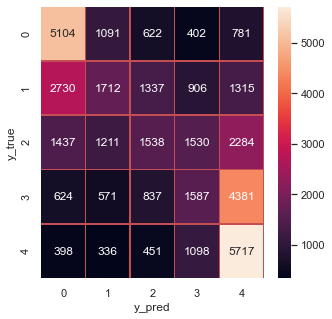

In [50]:
print ("Naive Bayes:\n")
confusion(ytest, ypred)

Ahi podemos calcular la precisión a mano. La pregunta es: cuando predice x estrellas, ¿con qué frecuencia es correcto?

(0 = 1 estrella, 1 = 2 estrellas etc.)

1 estrella: La prediccion de 1 estrella, cuando los verdaderos valores era 1 es 5104.
2 estrellas: La prediccion de 2 estrellas, cuando los verdaderos valores era 2 es 2730.
3 estrellas: La prediccion de 3 estrellas, cuando los verdaderos valores era 3 es 1437.
4 estrellas: La prediccion de 4 estrellas, cuando los verdaderos valores era 4 es 624.
5 estrellas: La prediccion de 5 estrellas, cuando los verdaderos valores era 5 es 398.

El total es: 10293 

Calculamos la precision:
1 estrella: (100/10293) * 5104 = 0.495. en 50% era preciso el modelo cuando predició 1 estrella.

### 8. Multinomial NB

En el aprendizaje automático, los clasificadores Naive Bayes son ampliamente utilizados para la clasificación porque, cuando se asume la independencia, son fáciles de implementar y rinden mejores resultados que otros predictores sofisticados.
Los clasificadores de Naive Bayes se basan en la teoría de Bayes y asumen que la ocurrencia o ausencia de una característica no influye en la presencia o ausencia de alguna otra característica

In [51]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
mnb = MultinomialNB()

In [52]:
parameters = {
    'alpha': (1, 1e-2, 1e-3)
}

grid_search_tune = GridSearchCV(mnb, parameters, cv=10, n_jobs=2, verbose=3)
grid_search_tune.fit(xtrain, ytrain)

print("Best parameters set:")
print (grid_search_tune.best_estimator_)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  4.9min finished


Best parameters set:
MultinomialNB(alpha=1)


In [53]:

grid_search_tune.best_score_
grid_search_tune.best_params_
grid_search_tune.best_estimator_ 

MultinomialNB(alpha=1)

In [54]:
print("acc : ", grid_search_tune.score(xtest,ytest))

acc :  0.493675


In [55]:
y_pred_mnb = grid_search_tune.predict(xtest)
y_pred_mnb

array([1, 1, 2, ..., 1, 4, 2], dtype=int64)

In [56]:
print(classification_report(ytest, y_pred_mnb, target_names = target_names))
confusion_matrix(ytest, y_pred_mnb)

              precision    recall  f1-score   support

  1 estrella       0.62      0.64      0.63      8000
 2 estrellas       0.42      0.43      0.43      8000
 3 estrellas       0.40      0.36      0.38      8000
 4 estrellas       0.42      0.42      0.42      8000
 5 estrellas       0.59      0.61      0.60      8000

    accuracy                           0.49     40000
   macro avg       0.49      0.49      0.49     40000
weighted avg       0.49      0.49      0.49     40000



array([[5158, 1959,  511,  212,  160],
       [1834, 3478, 1798,  593,  297],
       [ 777, 1944, 2916, 1721,  642],
       [ 299,  571, 1466, 3323, 2341],
       [ 192,  366,  596, 1974, 4872]], dtype=int64)

El accuracy subió a 49% con el Multinomial Naive Bayes. Ya se mejoró.

Hacemos Cross Validation. 

In [57]:
from sklearn.model_selection import cross_val_score
cv = cross_val_score(grid_search_tune, xtest, ytest, scoring='f1_macro', cv=5).mean()

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:   56.7s finished


Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:   56.8s finished


Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:   57.6s finished


Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:   58.6s finished


Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  1.0min finished


In [58]:
cv

0.4734331054659452

Con Cross Validation Score da menos accuracy porque tratamos de evitar overfitting con creando subsets(k-folds). 

Multinomial Naive Bayes:



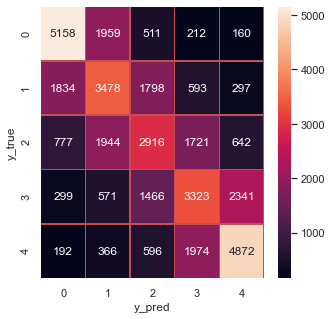

In [59]:
print ("Multinomial Naive Bayes:\n")
confusion(ytest, y_pred_mnb)

### 9. Let's check!

In [62]:
x = "no me gusta este producto para nada"

In [63]:
vec = tfidf.transform([x])
grid_search_tune.predict(vec)

array([4], dtype=int64)

Esperamos array([1]) lo cual significa 1 estrella. No nos predició bien. Por lo que veo es que la palabra "gusta" lo reconoció como positivo, pero ignoró "no" y "nada". 

In [64]:
x ="el mejor producto, buenisimo. muchas gracias"

In [65]:
vec = tfidf.transform([x])

grid_search_tune.predict(vec)

array([5], dtype=int64)

Esto el MNB lo hizo muy bien. Predijó 5 estrellas para esta vector. Nada mal! 

In [66]:
x = "me gusta mucho el producto pero muy malo el servicio"

In [67]:
vec = tfidf.transform([x])

grid_search_tune.predict(vec)

array([1], dtype=int64)

Acá se está confundiendo el modelo por la contradicción que tiene nuestra frase. Creo acá vamos a necesitar entrenar el training set con juntos de palabras.

### 10. Random Forest
Los Random Forests crean árboles de decisión en muestras de datos seleccionadas al azar, obtiene predicciones de cada árbol y selecciona la mejor solución mediante votación. También proporciona un indicador bastante bueno de la importancia de la característica.

In [70]:
x = matriz_titulos_fin.toarray()
y = stars

Hacemos el GridSearch para encontrar los mejores parametros:

In [71]:
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
# Build a classification task using 3 informative features
x, y = make_classification(n_samples=1000,
                           n_features=10,
                           n_informative=3,
                           n_redundant=0,
                           n_repeated=0,
                           n_classes=2,
                           random_state=0,
                           shuffle=False)


rf = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

param_grid = { 
    'n_estimators': [64, 128, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth'   : [None, 2, 5, 10],
    'n_jobs'      : [-1, 1]
}

CV_rfc = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)
CV_rfc.fit(x, y)
print(CV_rfc.best_params_)

{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 64, 'n_jobs': 1}


In [72]:
rf1 = RandomForestClassifier(n_estimators=64, max_depth= 10, n_jobs=1 ,max_features= 'sqrt', verbose = 1)

rf1.fit(xtrain, ytrain)
print("acc : ", rf1.score(xtest,ytest))


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


acc :  0.430925


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.3s finished


In [73]:
y_pred_rf1 = rf1.predict(xtest)
y_pred_rf1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.3s finished


array([1, 1, 1, ..., 2, 4, 2], dtype=int64)

In [74]:
print(classification_report(ytest, y_pred_rf1, target_names = target_names))
confusion_matrix(ytest, y_pred_rf1)

              precision    recall  f1-score   support

  1 estrella       0.54      0.67      0.60      8000
 2 estrellas       0.31      0.39      0.34      8000
 3 estrellas       0.36      0.29      0.32      8000
 4 estrellas       0.41      0.30      0.34      8000
 5 estrellas       0.53      0.52      0.52      8000

    accuracy                           0.43     40000
   macro avg       0.43      0.43      0.42     40000
weighted avg       0.43      0.43      0.42     40000



array([[5320, 1830,  458,  144,  248],
       [2457, 3085, 1472,  493,  493],
       [1066, 2476, 2288, 1365,  805],
       [ 522, 1427, 1467, 2368, 2216],
       [ 479, 1235,  724, 1386, 4176]], dtype=int64)

Random Forest Classifier:



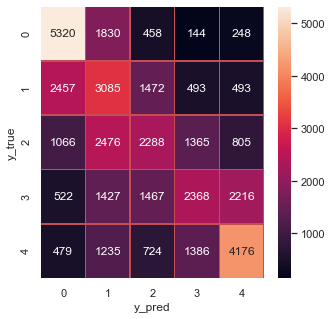

In [75]:
print ("Random Forest Classifier:\n")
confusion(ytest,y_pred_rf1)

Vamos a ver qué información utiliza el Random Forest para predecir e interpretar ese resultado.
Estas características son más importantes para explicar la variable de target.

C:\Users\Maartje\anaconda3\envs\acamica\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


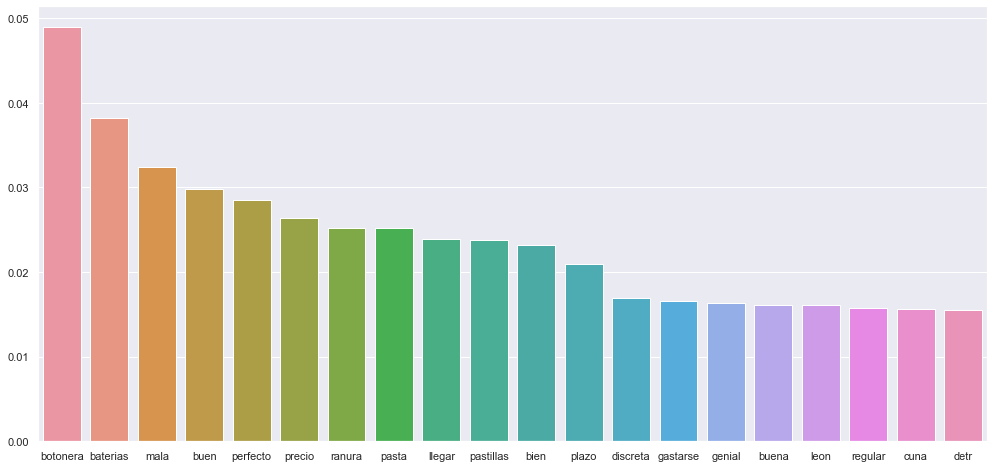

In [76]:
# Le preguntamos la importancia de cada feature (cada palabra)
importances = rf1.feature_importances_
# Tomamos la lista de palabras
all_words = tfidf.get_feature_names()
columns = all_words

# Ordenamos por importnacia y tomamos las 20 primeras
indices = np.argsort(importances)[::-1]
indices = indices[:20]
selected_columns = [columns[i] for i in indices]
selected_importances = importances[indices]

# Por ultimo graficamos
plt.figure(figsize = (17,8))
sns.barplot(selected_columns, selected_importances)
plt.show()

No coincide mucho con lo que esperaba a partir de mi experiencia con el dataset, porque usa palabras como "baterias" para precedir la estrella. Obviamente no ayuda mucho esta palabra en detectar sentimiento. Habrá que filtrar por formas gramaticales en combinación con pronombres. Osea qué combinaciones de palabras resultan en qué cantidad de estrellas. Serian palabras y conjuntos de palabras como malo, bueno, muy bueno, bien mal :-)

In [77]:
tfidf.vocabulary_

{'dinero': 1475,
 'tirado': 4680,
 'basura': 502,
 'compra': 970,
 'solo': 4451,
 'llega': 2794,
 'unidad': 4799,
 'comprar': 977,
 'producto': 3803,
 'recibido': 4007,
 'devuelto': 1439,
 'lleg': 2793,
 'horroroso': 2388,
 'funcional': 2139,
 'llego': 2801,
 'mala': 2866,
 'calidad': 667,
 'defectuoso': 1281,
 'descripci': 1360,
 'saltan': 4278,
 'utilizarla': 4830,
 'pegamento': 3476,
 'pesimo': 3565,
 'mariposa': 2957,
 'roto': 4235,
 'recomendable': 4026,
 'ojal': 3305,
 'demasiado': 1316,
 'fragil': 2096,
 'cristina': 1150,
 'aver': 441,
 'segundo': 4325,
 'parece': 3410,
 'buena': 610,
 'informaci': 2517,
 'internet': 2581,
 'despues': 1405,
 'apenas': 336,
 'material': 2977,
 'malo': 2881,
 'nunca': 3279,
 'dejado': 1297,
 'funcionar': 2146,
 'descontento': 1353,
 'pilar': 3602,
 'psulas': 3844,
 'tile': 4670,
 'estafa': 1853,
 'prime': 3782,
 'merece': 3032,
 'pena': 3502,
 'llegado': 2796,
 'todav': 4703,
 'bajisima': 463,
 'agujero': 155,
 'rellenar': 4087,
 'fatal': 2004,
 '

In [78]:
tfidf.vocabulary_.keys()

dict_keys(['dinero', 'tirado', 'basura', 'compra', 'solo', 'llega', 'unidad', 'comprar', 'producto', 'recibido', 'devuelto', 'lleg', 'horroroso', 'funcional', 'llego', 'mala', 'calidad', 'defectuoso', 'descripci', 'saltan', 'utilizarla', 'pegamento', 'pesimo', 'mariposa', 'roto', 'recomendable', 'ojal', 'demasiado', 'fragil', 'cristina', 'aver', 'segundo', 'parece', 'buena', 'informaci', 'internet', 'despues', 'apenas', 'material', 'malo', 'nunca', 'dejado', 'funcionar', 'descontento', 'pilar', 'psulas', 'tile', 'estafa', 'prime', 'merece', 'pena', 'llegado', 'todav', 'bajisima', 'agujero', 'rellenar', 'fatal', 'peores', 'protectores', 'puedes', 'montar', 'junta', 'stico', 'goma', 'porqueria', 'entrega', 'nefasto', 'manipulaci', 'faltaba', 'guantes', 'baja', 'rosa', 'compres', 'entregado', 'pone', 'timo', 'recomiendo', 'hojas', 'sueltas', 'recibe', 'proveedor', 'contesta', 'deforma', 'mucha', 'facilidad', 'llegue', 'culo', 'destino', 'cartucho', 'carga', 'hace', 'tarda', 'calentar', 'v

Habrá que filtar estas palabras y detectar solo los que son adjetivos. Asi el TFIDF ya puede vectorizar mejor, y salen solo las palabras que tiene significado. Esto es lo que pienso. Garbage in, garbage out :-(

### 11.Check Check!

In [79]:
x = "no me gusta este producto para nada"

In [80]:
vec = tfidf.transform([x])
rf1.predict(vec)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


array([2], dtype=int64)

Acá esperamos 1 estrella, nos dió 2. Lo cual no es super pero tampoco está muy mal. Alguien puede decir que no le gustó para nada el producto pero que da 2 estrellas porque el servicio de retorno fue bien. 

In [81]:
x ="el mejor producto, buenisimo. muchas gracias"

In [82]:
vec = tfidf.transform([x])

rf1.predict(vec)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


array([2], dtype=int64)

Aqui si debe de dar al menos 4 estrellas, y nos dio 2. Que mal. 

In [83]:
x = "me gusta mucho el producto pero muy malo el servicio"

In [84]:
vec = tfidf.transform([x])

rf1.predict(vec)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


array([1], dtype=int64)

La contradicción es bastante difícil de encontrar, y el Random Forest tiene muchas problemas con dar 2 o 3 estrellas. Dio 1. 

### 12. Support Vector Classifier

El objetivo de un SVC lineal (Support Vector Classifier) es adecuarse a los datos que proporcionamos, devolviendo un hiperplano “ideal” que divide o categoriza slos datos. Desde allí, después de obtener el hiperplano, podemos  alimentar algunas características al clasificador para ver lo que es lo predecido. El default es kernel rbf.



Voy a tratar de filtrar un poco mas nuestros datos, para que usa palabras que de verdad nos sirve predecir. 

In [85]:
from textblob import TextBlob

from nltk.corpus import stopwords
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC

In [86]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

# Define a word lemmatizer function
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

# Apply the word lemmatizer function to data
unpickled_df['titular_lem_title'] = unpickled_df['titular_lem_title'].apply(lemmatize_text)
unpickled_df.head()

,review_body,review_title,titular_lem_body,titular_lem_title,stars
0,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,bueno pantalla menos recibido respuesta fabric...,"[television, nevir]",1
1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,horrible comprar sabemos ingl inform tico desp...,"[dinero, tirado, basura, compra]",1
2,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,obligan comprar unidades llega solo forma recl...,"[solo, llega, unidad, obligan, comprar]",1
3,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,entro descalificar vendedor solo puedo decir t...,"[producto, recibido]",1
4,Llega tarde y co la talla equivocada,Devuelto,llega tarde talla equivocada,[devuelto],1


Vectorizamos:

In [87]:
cvec = CountVectorizer(min_df=.005, max_df=.9, ngram_range=(1,2), tokenizer=lambda doc: doc, lowercase=False)
cvec.fit(unpickled_df['titular_lem_title'])

C:\Users\Maartje\anaconda3\envs\acamica\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CountVectorizer(lowercase=False, max_df=0.9, min_df=0.005, ngram_range=(1, 2),
                tokenizer=<function <lambda> at 0x000001F8AD21DCA0>)

In [88]:
len(cvec.vocabulary_)


45

Si quisiera ser más o menos restrictivo en la selección de n-gram, podría ajustar los parámetros 'min_df' y 'max_df' dentro de mi CountVectorizer, que controla la cantidad mínima y máxima de documentos en cada palabra.

Ahora podemos abordar el siguiente paso, que es convertir este documento en una 'Bag of Words' de representación. Esto crea una columna separada para cada término que contiene el conteo dentro de cada documento. Después de eso, echaremos un vistazo a la sparsity de esta representación que nos permite saber cuántos nonzero values hay en el conjunto de datos porque el count vec nos puede dar muchos zeros. 

In [89]:
cvec_counts = cvec.transform(unpickled_df['titular_lem_title'])
print('sparse matrix shape:', cvec_counts.shape)
print('nonzero count:', cvec_counts.nnz)
print('sparsity: %.2f%%' % (100.0 * cvec_counts.nnz / (cvec_counts.shape[0] * cvec_counts.shape[1])))

sparse matrix shape: (200000, 45)
nonzero count: 140626
sparsity: 1.56%


Ahora que tenemos recuentos de términos para cada documento, el TfidfTransformer se puede aplicar para calcular el weight para cada término en cada documento:

In [90]:
transformer = TfidfTransformer()

transformed_weights = transformer.fit_transform(cvec_counts)
transformed_weights

<200000x45 sparse matrix of type '<class 'numpy.float64'>'
	with 140626 stored elements in Compressed Sparse Row format>

In [91]:
transformed_weights = transformed_weights.toarray()
vocab = cvec.get_feature_names()

model = pd.DataFrame(transformed_weights, columns=vocab)
model['Keyword'] = model.idxmax(axis=1)
model['Max'] = model.max(axis=1)
model['Sum'] = model.drop('Max', axis=1).sum(axis=1)
model.head(10)

,bastante,bien,bonita,bonito,buen,buen precio,buen producto,buena,buena calidad,buena compra,...,recomendable,recomiendo,regular,relaci,relaci calidad,tama,vale,Keyword,Max,Sum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,bastante,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,compra,1.000000,1.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,comprar,1.000000,1.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,producto,1.000000,1.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,bastante,0.000000,0.000000
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,lleg,1.000000,1.000000
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,bastante,0.000000,0.000000
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,bastante,0.000000,0.000000
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,bastante,0.000000,0.000000
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mala calidad,0.667697,1.707097


In [92]:
model = pd.merge(unpickled_df, model, left_index=True, right_index=True)
model.head()

,review_body,review_title,titular_lem_body,titular_lem_title,stars,bastante,bien,bonita,bonito,buen,...,recomendable,recomiendo,regular,relaci,relaci calidad,tama,vale,Keyword,Max,Sum
0,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,bueno pantalla menos recibido respuesta fabric...,"[television, nevir]",1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,bastante,0.0,0.0
1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,horrible comprar sabemos ingl inform tico desp...,"[dinero, tirado, basura, compra]",1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,compra,1.0,1.0
2,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,obligan comprar unidades llega solo forma recl...,"[solo, llega, unidad, obligan, comprar]",1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,comprar,1.0,1.0
3,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,entro descalificar vendedor solo puedo decir t...,"[producto, recibido]",1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,producto,1.0,1.0
4,Llega tarde y co la talla equivocada,Devuelto,llega tarde talla equivocada,[devuelto],1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,bastante,0.0,0.0


Si funcionó! Asi se ve nuestro nueva Dataframe. Con esto podemos calcular las palabras que mas están en el documento.

In [93]:
# Getting a view of the top 20 occurring words
occ = np.asarray(cvec_counts.sum(axis=0)).ravel().tolist()
counts_df = pd.DataFrame({'Term': cvec.get_feature_names(), 'Occurrences': occ})
counts_df.sort_values(by='Occurrences', ascending=False).head(25)

,Term,Occurrences
12,calidad,15610
1,bien,11890
7,buena,10006
36,precio,8603
4,buen,7672
37,producto,7388
13,calidad precio,4807
34,perfecto,4241
28,mala,4020
32,peque,3535


Parece que hay una inclinación positiva definida a través de estas palabras más populares, como 'calidad', 'bien' y 'buena'. Ahora, veamos si las 20 palabras con maximum weight arrojan una lista similar:

In [94]:
weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'Term': cvec.get_feature_names(), 'Weight': weights})
weights_df.sort_values(by='Weight', ascending=False).head(25)

,Term,Weight
1,bien,0.053182
12,calidad,0.044317
7,buena,0.030808
4,buen,0.026760
37,producto,0.026262
36,precio,0.023681
34,perfecto,0.020373
23,funciona,0.016243
32,peque,0.016037
11,bueno,0.014869


Es un diferente orden, pero muchas palabras coinciden! 

Llevamos esto al modelo: 

In [95]:
model.columns


Index(['review_body', 'review_title', 'titular_lem_body', 'titular_lem_title',
       'stars', 'bastante', 'bien', 'bonita', 'bonito', 'buen', 'buen precio',
       'buen producto', 'buena', 'buena calidad', 'buena compra',
       'buena relaci', 'bueno', 'calidad', 'calidad precio', 'compra',
       'comprar', 'correcto', 'ctico', 'cumple', 'demasiado', 'esperaba',
       'excelente', 'funci', 'funciona', 'funda', 'genial', 'lleg', 'llegado',
       'mala', 'mala calidad', 'malo', 'mejor', 'peque', 'perfecta',
       'perfecto', 'poca', 'precio', 'producto', 'recomendable', 'recomiendo',
       'regular', 'relaci', 'relaci calidad', 'tama', 'vale', 'Keyword', 'Max',
       'Sum'],
      dtype='object')

Usamos solo las columnas con palabras y no las que tienen los textos.

In [96]:
ml_model = model.drop(['review_body', 'review_title', 'titular_lem_body', 'titular_lem_title','Keyword', 'Max', 'Sum'], axis=1)

# Create X & y variables for Machine Learning
X = ml_model.drop('stars', axis=1)
y = ml_model['stars']

# Create a train-test split of these variables
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [97]:
from sklearn.model_selection import cross_val_predict

In [98]:
def model(mod, model_name, x_train, y_train, x_test, y_test):
    mod.fit(x_train, y_train)
    print(model_name)
    acc = cross_val_score(mod, X_train, y_train, scoring = "accuracy", cv = 5)
    predictions = cross_val_predict(mod, X_train, y_train, cv = 5)
    print("Accuracy:", round(acc.mean(),3))
    cm = confusion_matrix(predictions, y_train)
    print("Confusion Matrix:  \n", cm)
    print("                    Classification Report \n",classification_report(predictions, y_train))

In [99]:
svc = LinearSVC()
model(svc, "Linear SVC", X_train, y_train, X_test, y_test)

Linear SVC
Accuracy: 0.329
Confusion Matrix:  
 [[25126 21233 17120 13226 13212]
 [ 1057  2227  1615   694   812]
 [  413  1519  1910   775   389]
 [  901  2559  6311 10003  6586]
 [  524   616  1064  3281  6827]]
                    Classification Report 
               precision    recall  f1-score   support

           1       0.90      0.28      0.43     89917
           2       0.08      0.35      0.13      6405
           3       0.07      0.38      0.12      5006
           4       0.36      0.38      0.37     26360
           5       0.25      0.55      0.34     12312

    accuracy                           0.33    140000
   macro avg       0.33      0.39      0.28    140000
weighted avg       0.67      0.33      0.38    140000



Aunque el Linear SVC da mejor precisión en el primer estrella y un recall mas alto, eligeria al Random Forest sobre el Linear SVC. Los SVM trabajarián mejor con una problema binaria.  Tal vez me sirve usar un metodo como One-vs-Rest o One-vs-One para que anda mejor este modelo. 

El Random forest lo probé porque pueden aggarar con high dimensional noisy data. Aunque todavia no anda muy alto el accuracy, se ve que lo hace mejor qu el Linear SVC

De los 3 modelos el Multinomial Naive Bayes anda lo mejor, y es lo que esperaba tambien. 
Con el Multinomial Naive Bayes la ocurrencia de una característica no afecta la probabilidad de ocurrencia de la otra característica. Para tamaños de muestra pequeños, Naïve Bayes puede superar las alternativas más poderosas. Al ser relativamente robusto, fácil de implementar, rápido y preciso, se utiliza en muchos campos diferentes. Mejoró bastante a nuestra Benchmark Naive Bayes. 

Hice los otros modelos porque queria ver el resultado.  




Fuente:
https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

https://machinelearningmastery.com/one-vs-rest-and-one-vs-one-for-multi-class-classification/

https://www.mygreatlearning.com/blog/multinomial-naive-bayes-explained/

### Parte C - Investigación 

1. Debes explicar qué te gustaría probar, por qué y cómo lo harías. Si tienes referencias (por ejemplo, un artículo que hayas encontrado, capítulo de libro, etc.), debes mencionarlas.
    
    https://www.nltk.org/howto/collocations.html
    
    https://towardsdatascience.com/binary-and-multiclass-text-classification-auto-detection-in-a-model-test-pipeline-938158854943
    
    https://realpython.com/python-nltk-sentiment-analysis/
    
    https://medium.com/swlh/simple-sentiment-analysis-for-nlp-beginners-and-everyone-else-using-vader-and-textblob-728da3dbe33d
    
    https://towardsdatascience.com/basic-binary-sentiment-analysis-using-nltk-c94ba17ae386
    
    
2. Debes comentar también qué resultados esperas encontrar. Por ejemplo, puedes implementar una prueba rápida y mostrar resultados preliminare s, para ver si estás correctamente orientado.

 He estado pensando en dos cosas:
   ## 1. filtrar los reviews por los *stars*. Si consideramos 3 estrellas como neutral, podemos decir que 120.000 de los 200.000 reviews son positivos. Los 80.000 restantes son negativos. Hacemos una columna de positivos y uno de negativos y aprendemos qué palabras qu aparecen lo más en las dos columnas. Podemos enseñar al modelo esto, y luego hacer esto para cada 40.000 de 1,2,3,4 y 5 estrellas. 
    
   ##  2. Buscar en total las palabras mas usados y filtrar por formas gramaticales en combinación con pronombres. Osea qué combinaciones de palabras resultan en qué cantidad de estrellas. 

En hacer una problema binario tal vez seria mejor para el modelo aprender que palabras usar para la prediccion negativa y positiva. Ya cuando sabe los palabras más usados para cada estrella y el sentimiento de ellos relacionado a la estrella, podemos predecir las estrellas.

Pero mientras estaba haciendolo me di cuenta que no son dos cosas diferentes, sino es un proceso en total. Así que son pasos y no dos diferente ideas. :-) 

Vamos a verlo:

Agregamos una columna filtrando los estrellas en una columna binaria:

In [100]:
unpickled_df['rating'] = unpickled_df['stars'].replace(
               {1:'Low Rating', 2:'Low Rating', 3:'Low Rating',
                4:'High Rating', 5:'High Rating'})

unpickled_df.head(5)

,review_body,review_title,titular_lem_body,titular_lem_title,stars,rating
0,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,bueno pantalla menos recibido respuesta fabric...,"[television, nevir]",1,Low Rating
1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,horrible comprar sabemos ingl inform tico desp...,"[dinero, tirado, basura, compra]",1,Low Rating
2,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,obligan comprar unidades llega solo forma recl...,"[solo, llega, unidad, obligan, comprar]",1,Low Rating
3,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,entro descalificar vendedor solo puedo decir t...,"[producto, recibido]",1,Low Rating
4,Llega tarde y co la talla equivocada,Devuelto,llega tarde talla equivocada,[devuelto],1,Low Rating


In [101]:
unpickled_df.columns = unpickled_df.columns.str.strip()
unpickled_df.columns

Index(['review_body', 'review_title', 'titular_lem_body', 'titular_lem_title',
       'stars', 'rating'],
      dtype='object')

Hacemos diferente columnas por cada valor de *stars*  

In [102]:
sterretje = pd.get_dummies(unpickled_df['stars'])
mening = pd.get_dummies(unpickled_df['rating'])

In [103]:
df=pd.concat([unpickled_df.review_body, unpickled_df.review_title, unpickled_df.titular_lem_body, unpickled_df.titular_lem_title, unpickled_df.stars, sterretje, mening],axis=1)
#dataset_stem.dropna(axis=0,inplace=True)  # Por si quedaron titulares vacios
df.head()

,review_body,review_title,titular_lem_body,titular_lem_title,stars,1,2,3,4,5,High Rating,Low Rating
0,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,bueno pantalla menos recibido respuesta fabric...,"[television, nevir]",1,1,0,0,0,0,0,1
1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,horrible comprar sabemos ingl inform tico desp...,"[dinero, tirado, basura, compra]",1,1,0,0,0,0,0,1
2,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,obligan comprar unidades llega solo forma recl...,"[solo, llega, unidad, obligan, comprar]",1,1,0,0,0,0,0,1
3,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,entro descalificar vendedor solo puedo decir t...,"[producto, recibido]",1,1,0,0,0,0,0,1
4,Llega tarde y co la talla equivocada,Devuelto,llega tarde talla equivocada,[devuelto],1,1,0,0,0,0,0,1


##### TextBlob

TextBlob proporciona herramientas para clasificación,  part-of-speech tagging, extracción de sustantivos, Sentiment Analysis y más.

Extrayendo el sentimiento del texto, estamos esencialmente clasificando el texto como positivo, neutral o negativo. Esto puede ser referido como Polaridad. También podemos intentar calibrar la subjetividad del texto. 


Hacer un TextBlob:

In [104]:
review_blob = [TextBlob(review) for review in unpickled_df['titular_lem_body']]

df['tb_Pol'] = [b.sentiment.polarity for b in review_blob]
df['tb_Subj'] = [b.sentiment.subjectivity for b in review_blob]

In [105]:
df.head(20)

,review_body,review_title,titular_lem_body,titular_lem_title,stars,1,2,3,4,5,High Rating,Low Rating,tb_Pol,tb_Subj
0,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,bueno pantalla menos recibido respuesta fabric...,"[television, nevir]",1,1,0,0,0,0,0,1,0.0,0.00
1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,horrible comprar sabemos ingl inform tico desp...,"[dinero, tirado, basura, compra]",1,1,0,0,0,0,0,1,-1.0,1.00
2,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,obligan comprar unidades llega solo forma recl...,"[solo, llega, unidad, obligan, comprar]",1,1,0,0,0,0,0,1,0.0,0.00
3,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,entro descalificar vendedor solo puedo decir t...,"[producto, recibido]",1,1,0,0,0,0,0,1,0.0,0.75
4,Llega tarde y co la talla equivocada,Devuelto,llega tarde talla equivocada,[devuelto],1,1,0,0,0,0,0,1,0.0,0.00
5,Jamás me llegó y el vendedor nunca contacto co...,Jamás me llegó,lleg vendedor nunca contacto conmigo pesar int...,[lleg],1,1,0,0,0,0,0,1,0.0,0.00
6,"El paraguas es de muy mala calidad,da la sensa...",Horroroso!!!,paraguas mala calidad sensaci romper abres cutre,[horroroso],1,1,0,0,0,0,0,1,0.0,0.00
7,Tuve que devolverla porque al ser triangular n...,Poco funcional,devolverla triangular agarra forma moda escrit...,[funcional],1,1,0,0,0,0,0,1,0.0,0.00
8,Estoy esperando despues de protestar varias ve...,No me llego,esperando despues protestar varias veces soluc...,[llego],1,1,0,0,0,0,0,1,0.0,0.00
9,"Defectuoso. En apariencia muy bien producto, p...","Mala calidad, defectuoso",defectuoso apariencia bien producto tercer vas...,"[mala, calidad, defectuoso]",1,1,0,0,0,0,0,1,0.0,1.00


La polaridad es un float en el rango [-1.0, 1.0] donde -1 es el más negativo y 1 es el más positivo. La subjetividad es un float en el rango [0.0, 1.0] donde 0.0 es muy objetivo y 1.0 es muy subjetivo.

##### VADER

Podemos usar VADER, que busca el Valence de una palabra. Es un lexicon que ya tiene las palabras apuntadas. 
Valence es basicamente un *score* que representa la alineación emocional intrínsica de la palabra. Por ejemplo, el estrés es valence negativa y el placer es valence positiva.

In [106]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Maartje\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [107]:
from nltk.sentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

df['compound'] = [analyzer.polarity_scores(v)['compound'] for v in df['titular_lem_body']]
df['neg'] = [analyzer.polarity_scores(v)['neg'] for v in df['titular_lem_body']]
df['neu'] = [analyzer.polarity_scores(v)['neu'] for v in df['titular_lem_body']]
df['pos'] = [analyzer.polarity_scores(v)['pos'] for v in df['titular_lem_body']]



In [108]:
df.sample(5)

,review_body,review_title,titular_lem_body,titular_lem_title,stars,1,2,3,4,5,High Rating,Low Rating,tb_Pol,tb_Subj,compound,neg,neu,pos
95068,Por el precio que pagas tienes lo que es calid...,Tienes lo que pagas,precio pagas calidad mala aunque hacen funcion...,[pagas],3,0,0,1,0,0,0,1,0.0,0.0,0.0000,0.0,1.000,0.000
10439,Box con mucha pena desde el primer día fallo d...,Defectuoso,mucha pena primer fallo mando aparato dise per...,[defectuoso],1,1,0,0,0,0,0,1,0.0,0.0,0.3182,0.0,0.827,0.173
138691,Muy bueno para mi terraza,Genial,bueno terraza,[genial],4,0,0,0,1,0,1,0,0.0,0.0,0.0000,0.0,1.000,0.000
94202,Está bien si eres muy fan de Harry Potter y lo...,No es hermético,bien harry potter quieres tener puro frikismo ...,"[herm, tico]",3,0,0,1,0,0,0,1,0.0,1.0,0.0000,0.0,1.000,0.000
38905,"Me duró una semana, me olvide d quitarlo en la...",Una ducha y a la basura,semana olvide quitarlo ducha rdida dinero tiempo,"[ducha, basura]",1,1,0,0,0,0,0,1,0.0,0.0,0.0000,0.0,1.000,0.000


In [109]:
positive = df[df['High Rating'].eq(1)]
positive.shape

(80000, 18)

In [110]:
negative = df[df['High Rating'].eq(0)]
negative.shape

(120000, 18)

Podemos ver que categorizó bien porque tenemos 3 x 4000 negativos (estrellas 1-3) y 2 x 4000 positivos (estrellas 4-5)

Ahora quiero ver los conjuntos de palabra mas común que usa VADER. 

In [111]:
words_pos = [w for w in positive['titular_lem_body']]
finder_pos = nltk.collocations.TrigramCollocationFinder.from_words(words_pos)

In [112]:
finder_pos.ngram_fd.most_common(2)
finder_pos.ngram_fd.tabulate(2)

             ('buena pinta veremos resultado', 'entrega pida siempre falta factura', 'bien pido') ('entrega pida siempre falta factura', 'bien pido', 'queda bien material duradero tama perfecto') 
                                                                                                1                                                                                                 1 


In [113]:
words_neg = [w for w in negative['titular_lem_body']]
finder_neg = nltk.collocations.TrigramCollocationFinder.from_words(words_neg)

In [114]:
finder_neg.ngram_fd.most_common(2)
finder_neg.ngram_fd.tabulate(2)

                                                                                                                                                               ('bueno pantalla menos recibido respuesta fabricante', 'horrible comprar sabemos ingl inform tico despu hora capaz instalarlo', 'obligan comprar unidades llega solo forma reclamar autentica estafa compreis') ('horrible comprar sabemos ingl inform tico despu hora capaz instalarlo', 'obligan comprar unidades llega solo forma reclamar autentica estafa compreis', 'entro descalificar vendedor solo puedo decir tras espera sigo producto contactar amazon reclamar reembolso amazon hace cargo problema desembolsado dinero devuelven perdida tiempo total palabras ustedes deciden') 
                                                                                                                                                                                                                                                                         

Ahi esta. No sé como hacer las frases a 2 palabras, o a los adjetivos que son lo mas importante. Esto seria algo de ver. 

In [115]:
nltk.download('names')

[nltk_data] Downloading package names to
[nltk_data]     C:\Users\Maartje\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!


True

In [116]:
positive_fd = nltk.FreqDist(positive)
negative_fd = nltk.FreqDist(negative)

common_set = set(positive_fd).intersection(negative_fd)

for word in common_set:
    del positive_fd[word]
    del negative_fd[word]

top_100_positive = {word for word, count in positive_fd.most_common(100)}
top_100_negative = {word for word, count in negative_fd.most_common(100)}

Aqui queria poner el set() en un dictionary, pero no sé por dónde me va mal. 

Vamos a probarlo con Bigram/Trigram: 

In [117]:
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

In [118]:
bigram_measures = nltk.collocations.BigramAssocMeasures()



In [119]:
positive_bigram_finder = nltk.collocations.BigramCollocationFinder.from_words([
    w for w in positive['titular_lem_body']])
negative_bigram_finder = nltk.collocations.BigramCollocationFinder.from_words([
    w for w in negative['titular_lem_body']])

In [120]:
text = positive['titular_lem_body'].astype(str)

finder = BigramCollocationFinder.from_words(text)
scored = positive_bigram_finder.score_ngrams(bigram_measures.raw_freq)
sorted(bigram for bigram, score in scored)

[('', 'corta grande'),
 ('',
  'entregado tiempo material buena calidad buena construcci satisfecho producto ponerle pega vendr bien traer cable corto samsung varios apple'),
 ('',
  'excelente auriculare iphone conectaron problemas ajustan perfectamente modos llevar duda recomiendo'),
 ('', 'ligero penas peso guarda bien casa compartimento guardar frio'),
 ('', 'molan mont escapa parte arriba baja buena calidad chulas igual foto'),
 ('',
  'momento funcionado perfectamente temporada viene sigue funcionando igual'),
 ('',
  'pongo estrellas falta comporta largo tiempo pronto cumple perfectamente funci tica atractiva permite llevar trastos suelo cargar incluso usarlo llevar comida tupper'),
 ('',
  'producto vino bien embalado dando buena sensaci abrirlo viene control remoto soporte gopro aspectos positivos destacar bastante largo sensaci vaya doblar suficientemente grueso poder agarrarlo miedo caiga puede mover control remoto incluso quitar usarlo modo pode aspecto negativo destacar mo

Creo estoy más o menos bien orientado, pero no llego a tener los conjuntos de palabras que me sirven más para entrenar. 


### Resumen del proyecto

¡Aplica Procesamiento del Lenguaje Natural, Sistemas de Recomendación y Series de Tiempo para resolver problemas de relevancia contemporánea!

La realización y entrega del Proyecto es individual.

### Entregables

Un Notebook de Jupyter con la resolución de la consigna. El Notebook debe poder ejecutarse sin errores. En el notebook debe estar el link al repositorio (por ejemplo, de GitHub) donde se pueda encontrar el proyecto entregado.


--------------   https://github.com/Maartjehey/Proyecto-03-Acamica  --------------

### Referencias

Apóyate en las bitácoras, los notebooks trabajados y las presentaciones vistas en clase para resolver tu proyecto. También será de mucha utilidad la documentación de las librerías de Python. No dudes en consultar comunidades online como Stack Overflow y, por supuesto, buscar en la web (googlear).

### Consigna

Elige **una de las tres opciones** de aplicación para elaborar tu proyecto. El objetivo es que apliques las herramientas aprendidas en el dominio que hayas seleccionado. Verás que para cualquiera de las opciones, el trabajo se organiza en tres partes:

    Parte A - Exploración de Datos. Todo proyecto de Ciencia de Datos empieza con un Análisis Exploratorio de Datos. Y todo Análisis Exploratorio de Datos debe responder preguntas.
    
    Parte B - Modelo de Machine Learning. En esta sección deberás aplicar las técnicas de Machine Learning aprendidas para crear un modelo predictivo a partir del dataset provisto.
    
    Parte C - Investigación. Las preguntas y cosas para probar nunca se agotan. El objetivo de esta sección es que sugieras cómo continuarías el proyecto, con el fin de mejorar el modelo o responder una pregunta que consideres interesante. En todos los notebooks dejamos algunas sugerencias, pero puedes proponer otras.

Aquí debajo encontrarás el notebook con las consignas y el dataset para cada caso. Ten en cuenta que este proyecto se monta sobre los proyectos anteriores, y que ya esperamos cierto grado de independencia de parte tuya. Por eso, las consignas y recomendaciones de los notebooks no son exhaustivas. Es decir, si hay un paso en el flujo de trabajo que no está mencionado en el notebook que te dejamos, no implica que no haya que hacerlo. **Recuerda que para ver lo que sí tiene que estar sin falta en tu entregable debes consultar el Checklist.**



# Opción 2: Procesamiento de Lenguaje Natural

Implementa un modelo para reconocer el puntaje asignado a un ítem de Amazon a partir de la crítica que hace un/a usuario/a.

    Dataset. Aquí puedes encontrar la descarga del dataset e información sobre el mismo aquí. Es importante que tengas en cuenta la licencia de este dataset.
    Notebook. Aquí te dejamos un notebook con algunas recomendaciones para tu trabajo.



### Checklist de evaluación

Sugerencias para desarrollar el proyecto:

    - La resolución del proyecto te puede enfrentar a desafíos que no trabajamos durante los encuentros. Es importante que desarrolles la capacidad de resolverlos. Para ello, consulta las bitácoras, las referencias, los notebooks vistos en clase, la documentación de la librería y, sobre todo, googlea.
    - Los pasos deben estar correctamente justificados.
    - Las preguntas que se respondan deben estar correctamente explicitadas.
    - Imagina que este proyecto lo usarías para presentar en una entrevista de trabajo, o que lo debes presentar en tu trabajo. Presta mucha atención a la redacción, presentación de gráficos, etc.

Antes de subir tu proyecto a la plataforma Acámica para que sea evaluado, verifica que el Notebook se ejecute sin errores. Además, asegúrate de cumplir con las siguientes condiciones (son las que los/as evaluadores/as tendrán en consideración al momento de corregir tu trabajo):

##### Parte A - Exploración de Datos

    1. El Análisis Exploratorio de Datos debe servir para comprender el dataset y todo el flujo de trabajo que le siga.
    
    2. Debes responder al menos una pregunta original con este dataset. La pregunta debe estar correctamente explicitada.

##### Parte B - Modelo de Machine Learning

    1. Debes evaluar correctamente el modelo que realices. Esto implica un correcto manejo de datos de Train y Test, elegir una métrica apropiada y justificar su elección, y comparar los resultados contra un modelo benchmark.
    
    2. Puedes aplicar más de una de las técnicas vistas para crear tus modelos. Pero ten en cuenta que es preferible un modelo bien hecho (apropiada transformación de datos, optimización de hiperparámetros y análisis de sus resultados) que muchos modelos a medias. En caso de entrenar más de un modelo, debes comparar sus resultados y justificar cuál elegirías.
    
    3. Si el modelo lo permite, debes explorar qué información utiliza para predecir e interpretar ese resultado. ¿Coincide con lo que esperabas a partir de tu experiencia con el dataset?

##### Parte C - Investigación

    1. Debes explicar qué te gustaría probar, por qué y cómo lo harías. Si tienes referencias (por ejemplo, un artículo que hayas encontrado, capítulo de libro, etc.), debes mencionarlas.
    
    2. Debes comentar también qué resultados esperas encontrar. Por ejemplo, puedes implementar una prueba rápida y mostrar resultados preliminares, para ver si estás correctamente orientado.